載入keras

In [1]:
import keras

keras.__version__

Using TensorFlow backend.


'2.2.5'

載入路透社資料集

In [2]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2113536/2110848 [==============================] - 0s 0us/step


輸出訓練資料個數

In [3]:
len(train_data)

8982

輸出測試資料個數

In [4]:
len(test_data)

2246

輸出第10筆訓練資料

In [5]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

Here's how you can decode it back to words, in case you are curious:

In [6]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

557056/550378 [==============================] - 0s 0us/step


In [7]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

The label associated with an example is an integer between 0 and 45: a topic index.

In [9]:
train_labels[10]

3

## Preparing the data

We can vectorize the data with the exact same code as in our previous example:

In [0]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

One-hot Encoding

In [0]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# Our vectorized training labels
one_hot_train_labels = to_one_hot(train_labels)
# Our vectorized test labels
one_hot_test_labels = to_one_hot(test_labels)

Note that there is a built-in way to do this in Keras, which you have already seen in action in our MNIST example:

In [0]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## Building our network

In [0]:
from tensorflow.python.keras import models
from tensorflow.python.keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

In [0]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Validating our approach

Let's set apart 1,000 samples in our training data to use as a validation set:

In [0]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

Now let's train our network for 20 epochs:

In [18]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 57ms/step - loss: 2.6861 - accuracy: 0.5144 - val_loss: 1.8410 - val_accuracy: 0.6260
Epoch 2/20
16/16 [==============================] - 1s 46ms/step - loss: 1.4593 - accuracy: 0.6972 - val_loss: 1.3516 - val_accuracy: 0.7000
Epoch 3/20
16/16 [==============================] - 1s 46ms/step - loss: 1.0604 - accuracy: 0.7700 - val_loss: 1.1494 - val_accuracy: 0.7430
Epoch 4/20
16/16 [==============================] - 1s 46ms/step - loss: 0.8399 - accuracy: 0.8152 - val_loss: 1.0343 - val_accuracy: 0.7690
Epoch 5/20
16/16 [==============================] - 1s 45ms/step - loss: 0.6713 - accuracy: 0.8589 - val_loss: 1.0268 - val_accuracy: 0.7840
Epoch 6/20
16/16 [==============================] - 1s 47ms/step - loss: 0.5357 - accuracy: 0.8898 - val_loss: 0.9289 - val_accuracy: 0.8110
Epoch 7/20
16/16 [==============================] - 1s 45ms/step - loss: 0.4320 - accuracy: 0.9126 - val_loss: 0.9229 - val_accuracy: 0.8070
Epoch 8/20
16

Let's display its loss and accuracy curves:

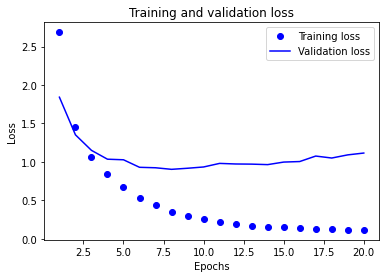

In [19]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [25]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

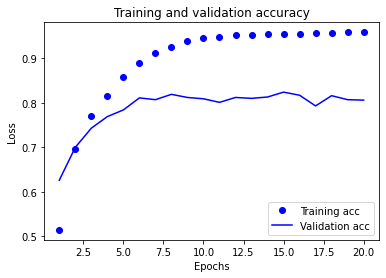

In [26]:
plt.clf()   # clear figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

It seems that the network starts overfitting after 8 epochs. Let's train a new network from scratch for 8 epochs, then let's evaluate it on 
the test set:

In [27]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=8,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/8
16/16 [==============================] - 1s 55ms/step - loss: 2.7082 - accuracy: 0.5195 - val_loss: 1.8074 - val_accuracy: 0.6540
Epoch 2/8
16/16 [==============================] - 1s 44ms/step - loss: 1.4693 - accuracy: 0.7081 - val_loss: 1.3125 - val_accuracy: 0.7210
Epoch 3/8
16/16 [==============================] - 1s 44ms/step - loss: 1.0578 - accuracy: 0.7816 - val_loss: 1.1372 - val_accuracy: 0.7480
Epoch 4/8
16/16 [==============================] - 1s 44ms/step - loss: 0.8293 - accuracy: 0.8300 - val_loss: 1.0478 - val_accuracy: 0.7790
Epoch 5/8
16/16 [==============================] - 1s 43ms/step - loss: 0.6656 - accuracy: 0.8658 - val_loss: 0.9858 - val_accuracy: 0.7850
Epoch 6/8
16/16 [==============================] - 1s 44ms/step - loss: 0.5341 - accuracy: 0.8918 - val_loss: 0.9236 - val_accuracy: 0.8040
Epoch 7/8
16/16 [==============================] - 1s 45ms/step - loss: 0.4345 - accuracy: 0.9117 - val_loss: 0.8975 - val_accuracy: 0.8150
Epoch 8/8
71/71 [===

In [28]:
results

[0.9997836947441101, 0.7947462201118469]


Our approach reaches an accuracy of ~78%. With a balanced binary classification problem, the accuracy reached by a purely random classifier 
would be 50%, but in our case it is closer to 19%, so our results seem pretty good, at least when compared to a random baseline:

In [29]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.182546749777382

## Generating predictions on new data

We can verify that the `predict` method of our model instance returns a probability distribution over all 46 topics. Let's generate topic 
predictions for all of the test data:

In [0]:
predictions = model.predict(x_test)

Each entry in `predictions` is a vector of length 46:

In [31]:
predictions[0].shape

(46,)

In [32]:
predictions[0] #

array([1.2395560e-06, 1.0992272e-04, 3.3915057e-05, 9.5319092e-01,
       4.1090526e-02, 1.7485967e-05, 5.0080107e-05, 3.7058133e-05,
       1.7313999e-03, 2.0358340e-05, 1.6877288e-05, 1.3023034e-04,
       1.3460837e-04, 7.0732247e-05, 1.5547686e-05, 2.8402781e-05,
       2.1943940e-04, 4.0266175e-05, 6.0212897e-06, 4.2649134e-04,
       7.3106441e-04, 3.0590020e-04, 8.9176427e-07, 5.6349872e-05,
       1.6581129e-06, 2.4975887e-05, 1.6036081e-05, 4.5524826e-06,
       2.7283888e-05, 2.2955441e-04, 1.0964496e-04, 2.3210210e-05,
       1.5506010e-04, 1.7483599e-05, 2.8177987e-05, 2.5868994e-05,
       2.8725239e-04, 1.1125978e-05, 8.2359766e-06, 2.7437042e-04,
       4.0083060e-06, 2.0479161e-04, 1.0181224e-05, 1.8354800e-05,
       4.8675312e-05, 3.8660819e-06], dtype=float32)

The coefficients in this vector sum to 1:

In [33]:
np.sum(predictions[0])

1.0

The largest entry is the predicted class, i.e. the class with the highest probability:

In [34]:
np.argmax(predictions[0])

3

## A different way to handle the labels and the loss

We mentioned earlier that another way to encode the labels would be to cast them as an integer tensor, like such:

In [0]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)


The only thing it would change is the choice of the loss function. Our previous loss, `categorical_crossentropy`, expects the labels to 
follow a categorical encoding. With integer labels, we should use `sparse_categorical_crossentropy`:

In [0]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

This new loss function is still mathematically the same as `categorical_crossentropy`; it just has a different interface.

## On the importance of having sufficiently large intermediate layers


We mentioned earlier that since our final outputs were 46-dimensional, we should avoid intermediate layers with much less than 46 hidden 
units. Now let's try to see what happens when we introduce an information bottleneck by having intermediate layers significantly less than 
46-dimensional, e.g. 4-dimensional.

In [37]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 1s 18ms/step - loss: 3.3098 - accuracy: 0.2325 - val_loss: 2.7258 - val_accuracy: 0.4020
Epoch 2/20
63/63 [==============================] - 1s 16ms/step - loss: 2.3148 - accuracy: 0.4458 - val_loss: 2.1000 - val_accuracy: 0.4630
Epoch 3/20
63/63 [==============================] - 1s 16ms/step - loss: 1.8013 - accuracy: 0.5338 - val_loss: 1.6597 - val_accuracy: 0.6340
Epoch 4/20
63/63 [==============================] - 1s 16ms/step - loss: 1.2730 - accuracy: 0.7273 - val_loss: 1.3325 - val_accuracy: 0.6920
Epoch 5/20
63/63 [==============================] - 1s 16ms/step - loss: 1.0508 - accuracy: 0.7430 - val_loss: 1.2668 - val_accuracy: 0.6920
Epoch 6/20
63/63 [==============================] - 1s 16ms/step - loss: 0.9450 - accuracy: 0.7551 - val_loss: 1.2651 - val_accuracy: 0.6970
Epoch 7/20
63/63 [==============================] - 1s 16ms/step - loss: 0.8616 - accuracy: 0.7685 - val_loss: 1.2747 - val_accuracy: 0.7010
Epoch 8/20
63